# **<center>Package Installations and Library Imports<center>**

---



In [ ]:
pip install -U homeharvest

In [ ]:
pip install playwright



---



# **<center>Property Data Scraping Demo for Recent Data <center>**

---



In [ ]:
from homeharvest import scrape_property
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

#Ignore this we don't need it now, maybe ever
'''
************* We don't need this as of now *************


# Generate filename
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"HomeHarvest_{current_timestamp}.csv"

properties = scrape_property(
    location="San Diego, CA",
    listing_type="sold",
    past_days=30,
    # source="realtor",  # <— specify explicitly
)

# Confirm what we got
print(type(properties))
print(f"Number of properties: {len(properties)}")

if isinstance(properties, pd.DataFrame):
    properties.to_csv(filename, index=False)
    print(properties.head())
else:
    print(properties[:5])  # just preview the raw output
    '''

'\n************* We don\'t need this as of now *************\n\n\n# Generate filename\ncurrent_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")\nfilename = f"HomeHarvest_{current_timestamp}.csv"\n\nproperties = scrape_property(\n    location="San Diego, CA",\n    listing_type="sold",\n    past_days=30,\n    # source="realtor",  # <— specify explicitly\n)\n\n# Confirm what we got\nprint(type(properties))\nprint(f"Number of properties: {len(properties)}")\n\nif isinstance(properties, pd.DataFrame):\n    properties.to_csv(filename, index=False)\n    print(properties.head())\nelse:\n    print(properties[:5])  # just preview the raw output\n    '

In [ ]:

# Get properties as Pydantic models for type safety and data validation
# We can repeat this code with different cities to gather more diverse data
properties = scrape_property(
    location="Houston, TX",
    listing_type="sold",
    date_from="2020-01-01",
    date_to="2020-02-02",
    return_type="pydantic"  # Returns list of Property models
)

# Access model fields with full type hints and validation
for prop in properties[:5]: #Change this number to get more properties
    print(f"Address: {prop.address.formatted_address}")
    if prop.list_price is not None:
        print(f"Price: ${prop.list_price:,}")
    #else:
        #print("Price: N/A") # Or handle the None case as appropriate
    if prop.description:
        print(f"Beds: {prop.description.beds}, Baths: {prop.description.baths_full}")


# End of Current Housing Price Data Collection Code

RetryError: HTTPSConnectionPool(host='api.frontdoor.realtor.com', port=443): Max retries exceeded with url: /graphql (Caused by ResponseError('too many 403 error responses'))

In [ ]:
# DF Demo
property_dicts = [p.model_dump() for p in properties]
df = pd.DataFrame(property_dicts)
#Filters out listings with no listed price
df_filtered = df[df['list_price'].notnull()]
#Only displays property id and list price, customize as needed
df_reduced = pd.DataFrame(df_filtered, columns=['property_id', 'list_price'])
df_reduced.head(20)

In [ ]:
# CSV Demo
df_reduced.to_csv("houston_housing_data_2016.csv", index = False)

# **<center>Multiple Months and Locations at Once (Not Working)<center>**

---



In [ ]:
from typing import List, Dict, Any
import traceback
def scrape_month(location, date_from, date_to):
  """
  properties = scrape_property(
      location = location,
      listing_type = "sold",
      date_from = date_from,
      date_to=date_to,
      return_type="list[dict]"  # Change return type to list of dictionaries
  )

  if not properties: # Check if the list of dictionaries is empty
      return pd.DataFrame() # Return an empty DataFrame if no properties are found

  df = pd.DataFrame(properties)

  # Ensure 'description' column exists and is a dictionary before processing 'sold_price'
  if 'description' in df.columns:
      try:
        properties = scrape_property(
            location=location,
            listing_type="sold",
            date_from=date_from,
            date_to=date_to,
            return_type="list[dict]"
        )
      except Exception as e:
        print(f"scrape_property failed for {location} {date_from} -> {date_to}: {e}")
        traceback.print_exc()
        return pd.DataFrame()

  if not properties:
        return pd.DataFrame()

  df = pd.DataFrame(properties)

  if 'description' in df.columns:
        def extract_sold_price(desc):
            try:
                if isinstance(desc, dict):
                    sold = desc.get('sold_price') or desc.get('soldPrice') or desc.get('sold')
                    if sold in (None, ''):
                        return pd.NA
                    if isinstance(sold, (int, float)):
                        return int(sold)
                    s = str(sold).replace(',', '').replace('$', '').strip()
                    return int(s) if s.isdigit() else pd.NA
            except Exception:
                return pd.NA
            return pd.NA
        df['sold_price'] = df['description'].apply(extract_sold_price)

  df["city"] = location
  df["month"] = pd.to_datetime(date_from).month
  df["year"] = pd.to_datetime(date_from).year

  return df
  """
  # possible work around
  preferred = None
  for candidate in ("LIST", "LIST_DICT", "LIST_OF_DICTS", "list", "dataframe", "data_frame"):
        try:
            # prefer enum member when possible
            preferred = ReturnType[candidate]  # uses enum name
            break
        except Exception:
            # try value-based creation (some enums use lowercase values)
            try:
                preferred = ReturnType(candidate)
                break
            except Exception:
                preferred = None
        properties = None
        try:
          if preferred is not None:
            properties = scrape_property(
            location=location,
            listing_type="sold",
            date_from=date_from,
            date_to=date_to,
            return_type=preferred
            )
          else:
            # fallback: call without return_type (use library default)
            properties = scrape_property(
                location=location,
                listing_type="sold",
                date_from=date_from,
                date_to=date_to
            )
        except Exception as ex:
          print(f"scrape_property raised for {location} {date_from}->{date_to}: {ex}")
          traceback.print_exc()
          return pd.DataFrame()

    # Normalize to DataFrame
  if properties is None:
        return pd.DataFrame()

  if isinstance(properties, pd.DataFrame):
    df = properties.copy()
  elif isinstance(properties, list):
    # list of dicts expected
    df = pd.DataFrame(properties)
  elif isinstance(properties, dict):
    # single dict -> wrap into list
    df = pd.DataFrame([properties])
  else:
        # unknown type: try to coerce
      try:
          df = pd.DataFrame(properties)
      except Exception:
          raise TypeError(f"Unexpected return type from scrape_property: {type(properties)}")

    # optional: add metadata columns
  df['city'] = location
  try:
      df['month'] = pd.to_datetime(date_from).month
      df['year'] = pd.to_datetime(date_from).year
  except Exception:
      pass

  return df

In [ ]:
cities = ["Seattle, WA",
          "Denver, CO",
          "Aurora, CO",
          "Portland, OR",
          "Los Angeles, CA",
          "Cheyenne, WY",
          "Fort Worth, TX",
          "San Antonio, TX"]

time_ranges = [("2016-01-01", "2016-01-31"),
               ("2016-02-01", "2016-02-29"),
               ("2016-03-01", "2016-03-31")]

dfs = []

for city in cities:
  for date_from, date_to in time_ranges:
    try:
      print(f"Scraping {city} from {date_from} to {date_to} ...")
      df_month = scrape_month(city, date_from, date_to)
      if not df_month.empty:
        dfs.append(df_month)
    except Exception as e:
      print(f"Error scraping {city} {date_from}->{date_to}: {e}")
      traceback.print_exc()
    # possible work around
    """
    try:
      print(f"Scraping {city} from {date_from} to {date_to} ...")
      df_month = scrape_month(city, date_from, date_to)
      if not df_month.empty:
        dfs.append(df_month)
    except Exception as e:
      print(f"Error scraping {city} {date_from}->{date_to}: {e}")
    traceback.print_exc()
    """

if dfs:
  dfs_all = pd.concat(dfs, ignore_index=True)
  dfs_all = dfs_all[dfs_all['list_price'].notnull()]
  dfs_all.to_csv("housing_data_2016.csv", index = False)
  print("Saved housing_data_2016.csv with", len(dfs_all), "rows.")
else:
  print("No data collected.")

# <center> Correlation Heat Map <center>
---


In [ ]:
def read_bls_wide_csv(path):
    """
    Read a BLS-style wide CSV with header row like: Year,Jan,Feb,...,Dec
    Returns DataFrame with ['month', 'inflation'] (month = Timestamp of first day of month).
    """
    # detect header row containing "Year," at file start
    header_row = None
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for i, line in enumerate(f):
            if line.strip().lower().startswith("year,"):
                header_row = i
                break
    if header_row is None:
        header_row = 0

    df = pd.read_csv(path, header=header_row)
    cols = list(df.columns)
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    month_cols = [c for c in cols if any(m.lower() in str(c).lower() for m in months)]
    if not month_cols:
        raise ValueError("Could not find month columns in inflation CSV. Columns: " + ", ".join(cols[:20]))

    year_col = cols[0]
    df_long = df.melt(id_vars=[year_col], value_vars=month_cols, var_name='month_name', value_name='value')

    # convert month_name to month number
    def month_num_from_name(name):
        if pd.isna(name):
            return None
        name = str(name)
        for i, m in enumerate(months, start=1):
            if m.lower() in name.lower():
                return i
        return None

    df_long['month'] = df_long['month_name'].apply(month_num_from_name)
    df_long['year'] = pd.to_numeric(df_long[year_col], errors='coerce')

    # drop rows where we couldn't parse year or month number
    df_long = df_long.dropna(subset=['year','month'])

    # ensure integer month values
    df_long['month'] = df_long['month'].astype(int)
    df_long['year']  = df_long['year'].astype(int)

    # build timestamp from year+month (first day)
    df_long['month'] = pd.to_datetime(df_long[['year', 'month']].assign(day=1))

    df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')

    out = df_long.groupby('month')['value'].mean().reset_index().rename(columns={'value':'inflation'})
    return out

Saving mortgage_rates.csv to mortgage_rates.csv
Saving inflation_rates_us.csv to inflation_rates_us.csv

Inflation (monthly) sample:
       month  inflation
0 1958-01-01        3.2
1 1958-02-01        3.2
2 1958-03-01        2.8
3 1958-04-01        2.4
4 1958-05-01        2.4

Mortgage (monthly) sample:
       month  mortgage_rate
0 1971-04-01         7.3100
1 1971-05-01         7.4250
2 1971-06-01         7.5300
3 1971-07-01         7.6040
4 1971-08-01         7.6975

Housing (monthly) sample:
       month  median_sold_price
0 2016-01-01           459500.0
1 2016-02-01           471250.0
2 2016-03-01           500000.0

Saved heatmap to: correlation_heatmap.png


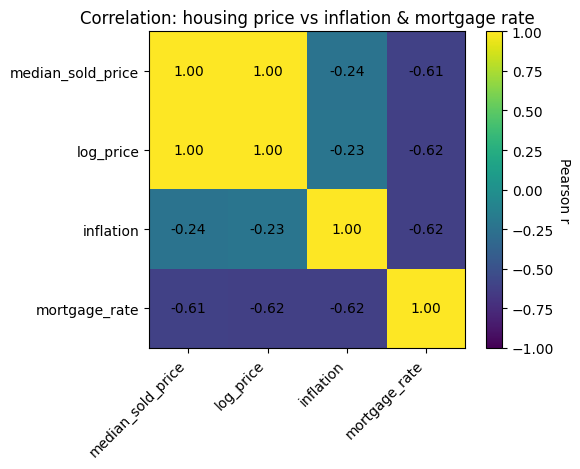

In [ ]:
#inflation_rates_us 1(BLS Data Series)


####
####
#### # Could not get the cvs file to be uploaded form the computer to the notebook
####
####



# Correlation heatmap: housing prices vs inflation, mortgage rates, etc.
import numpy as np
import os

# We Manually Select the files from the computer using the files import because google colab can't navigate the file directory
from google.colab import files
uploaded = files.upload()

# find first existing column name
def first_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Load housing data, inflation data, and mortgage data
inflation_path_candidates = ["inflation_rates_us.csv", "inflation_rates_us 1(BLS Data Series).csv"]
mortgage_path_candidates = ["mortgage_rates.csv", "mortgage_rates_fred.csv"]
housing_path_candidates = ["housing_data_2016.csv", "housing_data.csv"]

def find_first(names):
    for n in names:
        if os.path.exists(n):
            return n
        p = os.path.join("/mnt/data", n)
        if os.path.exists(p):
            return p
        p2 = os.path.join("/content", n)
        if os.path.exists(p2):
            return p2
    return None

inflation_path = find_first(inflation_path_candidates)
mortgage_path  = find_first(mortgage_path_candidates)
housing_path   = find_first(housing_path_candidates)



housing = pd.read_csv(housing_path)

# common sold date and price column candidates
date_col = first_col(housing, ["sold_date", "soldAt", "sale_date", "sold_at", "date", "soldDate", "last_sold_date"])
price_col = first_col(housing, ["sold_price", "sale_price", "price", "list_price", "soldPrice", "sold_price"])

####--------------------------------------Date Not Found------------------------------------------------------------####
if date_col is None or price_col is None:
    raise ValueError(f"Could not find date or price columns. Found date: {date_col}, price: {price_col}")

# parse date and aggregate monthly (median price is robust to outliers)
housing[date_col] = pd.to_datetime(housing[date_col], errors="coerce")
housing = housing.dropna(subset=[date_col, price_col])
housing['month'] = housing[date_col].dt.to_period('M').dt.to_timestamp()
housing['price_numeric'] = pd.to_numeric(housing[price_col], errors='coerce')
monthly_price = housing.groupby('month')['price_numeric'].median().rename('median_sold_price').reset_index()

# monthly_price['median_sold_price_smoothed'] = monthly_price['median_sold_price'].rolling(3, center=True, min_periods=1).median()

# Load external factor data
# Provide CSVs with at least a date column and a value column

# There is difficulty in finding the path of the inflation and mortgage csv files
#inflation_path = "/Users/swastikraj/Downloads/inflation_rates_us.csv"
#mortgage_path = "/Users/swastikraj/Downloads/mortgage_rates.csv"

## Inflation Monthly

inflation_monthly = read_bls_wide_csv(inflation_path)
print("\nInflation (monthly) sample:")
print(inflation_monthly.head())


# NOT WORKING
mortgage_raw = pd.read_csv(mortgage_path)
if 'observation_date' in mortgage_raw.columns and 'MORTGAGE30US' in mortgage_raw.columns:
    mortgage_raw = mortgage_raw.rename(columns={'observation_date':'date','MORTGAGE30US':'value'})
else:
    # try to auto-detect a date-like column and the first numeric column
    date_candidates = [c for c in mortgage_raw.columns if any(k in c.lower() for k in ('date','observ','month'))]
    numeric_candidates = [c for c in mortgage_raw.columns if pd.to_numeric(mortgage_raw[c], errors='coerce').notna().sum() > 0]
    if date_candidates and numeric_candidates:
        mortgage_raw = mortgage_raw.rename(columns={date_candidates[0]:'date', numeric_candidates[0]:'value'})
    else:
        raise ValueError("Could not detect date/value columns in mortgage CSV. Columns: " + ", ".join(mortgage_raw.columns))

mortgage_raw['date'] = pd.to_datetime(mortgage_raw['date'], errors='coerce')
mortgage_raw['value'] = pd.to_numeric(mortgage_raw['value'], errors='coerce')
mortgage_raw = mortgage_raw.dropna(subset=['date'])
mortgage_monthly = mortgage_raw.groupby(mortgage_raw['date'].dt.to_period('M'))['value'].mean().reset_index()
mortgage_monthly['month'] = mortgage_monthly['date'].dt.to_timestamp()
mortgage_monthly = mortgage_monthly[['month','value']].rename(columns={'value':'mortgage_rate'})
print("\nMortgage (monthly) sample:")
print(mortgage_monthly.head())


##

housing = pd.read_csv(housing_path, low_memory=False)
if 'last_sold_date' in housing.columns:
    date_col = 'last_sold_date'
elif 'list_date' in housing.columns:
    date_col = 'list_date'
else:
    # try other likely names
    date_candidates = [c for c in housing.columns if any(k in c.lower() for k in ('sold','date','closed','closed_date'))]
    date_col = date_candidates[0] if date_candidates else None

if 'sold_price' in housing.columns:
    price_col = 'sold_price'
elif 'list_price' in housing.columns:
    price_col = 'list_price'
else:
    num_candidates = [c for c in housing.columns if pd.to_numeric(housing[c], errors='coerce').notna().sum() > 0]
    price_col = num_candidates[0] if num_candidates else None

if date_col is None or price_col is None:
    raise ValueError("Could not find suitable date and price columns in housing CSV. Columns: " + ", ".join(housing.columns[:40]))

housing[date_col] = pd.to_datetime(housing[date_col], errors='coerce')
housing[price_col] = pd.to_numeric(housing[price_col], errors='coerce')
housing = housing.dropna(subset=[date_col, price_col])
monthly_price = housing.groupby(housing[date_col].dt.to_period('M'))[price_col].median().reset_index()
monthly_price['month'] = monthly_price[date_col].dt.to_timestamp()
monthly_price = monthly_price[['month', price_col]].rename(columns={price_col:'median_sold_price'})
print("\nHousing (monthly) sample:")
print(monthly_price.head())

##
df = monthly_price.merge(inflation_monthly, on='month', how='inner').merge(mortgage_monthly, on='month', how='inner')
df = df.sort_values('month').reset_index(drop=True)
if df.empty:
    raise ValueError("Merged dataframe empty — check date ranges or formats of input files.")

df['median_sold_price'] = pd.to_numeric(df['median_sold_price'], errors='coerce')
df['inflation'] = pd.to_numeric(df['inflation'], errors='coerce')
df['mortgage_rate'] = pd.to_numeric(df['mortgage_rate'], errors='coerce')
df['log_price'] = np.log(df['median_sold_price'])

df_corr = df[['median_sold_price','log_price','inflation','mortgage_rate']].dropna(how='any')
corr = df_corr.corr(method='pearson')


##

labels = corr.columns.tolist()
n = len(labels)
fig, ax = plt.subplots(figsize=(1.5*n, 1.2*n))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)

for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center', fontsize=10)

cbar = fig.colorbar(im, ax=ax, fraction=0.050, pad=0.05)
cbar.ax.set_ylabel('Pearson r', rotation=270, labelpad=12)
ax.set_title('Correlation: housing price vs inflation & mortgage rate')
plt.tight_layout()

out_name = "correlation_heatmap.png"
fig.savefig(out_name, dpi=200, bbox_inches='tight')
print("\nSaved heatmap to:", out_name)
plt.show()



In [ ]:

housing = pd.read_csv("housing_data_2016.csv")
print(housing.columns.tolist())

['property_url', 'property_id', 'listing_id', 'permalink', 'mls', 'mls_id', 'status', 'mls_status', 'text', 'style', 'formatted_address', 'full_street_line', 'street', 'unit', 'city', 'state', 'zip_code', 'beds', 'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls', 'list_price', 'list_price_min', 'list_price_max', 'list_date', 'pending_date', 'sold_price', 'last_sold_date', 'last_sold_price', 'last_status_change_date', 'last_update_date', 'assessed_value', 'estimated_value', 'tax', 'tax_history', 'new_construction', 'lot_sqft', 'price_per_sqft', 'latitude', 'longitude', 'neighborhoods', 'county', 'fips_code', 'stories', 'hoa_fee', 'parking_garage', 'agent_id', 'agent_name', 'agent_email', 'agent_phones', 'agent_mls_set', 'agent_nrds_id', 'broker_id', 'broker_name', 'builder_id', 'builder_name', 'office_id', 'office_mls_set', 'office_name', 'office_email', 'office_phones', 'nearby_schools', 'primary_photo', 'alt_photos', 'month', 'year']


In [ ]:
from google.colab import files
#files.download("houston_housing_data_2016.csv")
#files.download("housing_data_2016.csv")

In [ ]:
# Required imports
import os
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# (Optional) If you haven't uploaded yet, uncomment:
# uploaded = files.upload()

# Helper: first existing column name among candidates
def first_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# Helper: find first path among a list of candidate filenames/locations
def find_first(names):
    for n in names:
        # check relative path in working dir
        if os.path.exists(n):
            return n
        # check /mnt/data (common in some environments)
        p = os.path.join("/mnt/data", n)
        if os.path.exists(p):
            return p
        # check /content (Colab upload default)
        p2 = os.path.join("/content", n)
        if os.path.exists(p2):
            return p2
    return None

# Candidate filenames (include the two you uploaded earlier)
inflation_path_candidates = ["inflation_rates_us.csv", "inflation_rates_us 1(BLS Data Series).csv"]
mortgage_path_candidates = ["mortgage_rates.csv", "mortgage_rates_fred.csv"]
housing_path_candidates = ["housing_data_2016.csv", "housing_data.csv",
                           "houston_housing_data_2016.csv", "/mnt/data/housing_data_2016.csv",
                           "/mnt/data/houston_housing_data_2016.csv"]

inflation_path = find_first(inflation_path_candidates)
mortgage_path  = find_first(mortgage_path_candidates)
housing_path   = find_first(housing_path_candidates)

print("Detected paths:")
print("  housing_path:", housing_path)
print("  inflation_path:", inflation_path)
print("  mortgage_path:", mortgage_path)

if housing_path is None:
    raise FileNotFoundError("No housing CSV found. Make sure you uploaded 'housing_data_2016.csv' or 'houston_housing_data_2016.csv' using files.upload().")

# If there is also a houston-specific file present, try to use both
houston_path = find_first(["houston_housing_data_2016.csv", "/mnt/data/houston_housing_data_2016.csv", "/content/houston_housing_data_2016.csv"])

# --- LOAD DATA (robust) ---
df_main = pd.read_csv(housing_path)
df_list = [df_main]

if houston_path and os.path.abspath(houston_path) != os.path.abspath(housing_path):
    try:
        df_hou = pd.read_csv(houston_path)
        df_list.append(df_hou)
        print("Found and loaded houston file too:", houston_path)
    except Exception as e:
        print("Could not read houston file at", houston_path, ":", e)

# Try to concatenate if possible (will still work if only one df in list)
try:
    df = pd.concat(df_list, ignore_index=True, sort=False)
    print("Combined dataframe shape:", df.shape)
except Exception as e:
    print("Concatenation failed, using the first dataframe only. Error:", e)
    df = df_list[0].copy()
    print("Using shape:", df.shape)

# --- Locate a plausible target column ---
target_candidates = ["list_price", "ListPrice", "price", "Price", "sale_price", "salePrice"]
target = first_col(df, target_candidates)

if target is None:
    # Print a short sample of columns to help you pick
    print("\nCouldn't find an automatic target column. Columns present (first 40):")
    print(df.columns[:40].tolist())
    raise ValueError("Please rename or indicate the target column (e.g., 'list_price') and re-run.")

print("\nUsing target column:", target)

# --- Keep numeric columns only and prepare features/target ---
numeric_df = df.select_dtypes(include=[np.number]).copy()
print("Numeric-only shape:", numeric_df.shape)

# Ensure target is numeric (if it's non-numeric but convertible, try converting)
if target not in numeric_df.columns:
    # try coercing target into numeric and reintegrating
    try:
        numeric_target = pd.to_numeric(df[target], errors="coerce")
        if numeric_target.notna().sum() > 0:
            numeric_df[target] = numeric_target
            print(f"Coerced target '{target}' to numeric and added to numeric_df.")
        else:
            raise ValueError
    except Exception:
        raise ValueError(f"Target '{target}' is not present as numeric. Found numeric columns: {numeric_df.columns.tolist()}")

# Drop columns that are entirely NaN (these break SimpleImputer)
all_nan_cols = numeric_df.columns[numeric_df.isna().all()].tolist()
if all_nan_cols:
    print("Dropping columns with all NaN values (these cannot be imputed):", all_nan_cols)
    numeric_df = numeric_df.drop(columns=all_nan_cols)
print("After dropping all-NaN cols shape:", numeric_df.shape)

# Prepare X and y
X = numeric_df.drop(columns=[target])
y = numeric_df[target]

if X.shape[1] == 0:
    raise ValueError("No features remain after cleaning. Please include numeric feature columns in your CSV.")

# Optional: log-transform the target to stabilize variance (uncomment if desired)
# import numpy as np
# y = np.log1p(y)   # remember to np.expm1() predictions when evaluating back on natural scale

# --- Train / test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# --- Pipeline with imputer + linear regression ---
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # fill remaining NaNs with column mean
    ("lr", LinearRegression())
])

pipeline.fit(X_train, y_train)

# --- Evaluate ---
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel performance on test set: MSE = {mse:.4f}, R² = {r2:.6f}")

# --- Coefficients aligned with feature names ---
coeffs = pipeline.named_steps['lr'].coef_
features = X.columns

if len(coeffs) != len(features):
    raise ValueError(f"Length mismatch between coefficients ({len(coeffs)}) and features ({len(features)}).")

coef_df = pd.DataFrame({"feature": features, "coefficient": coeffs})
coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)  # sort by magnitude

print("\nTop coefficients (by absolute value):")
print(coef_df.head(30))

# --- Save the cleaned numeric dataset so you can inspect / reuse it ---
out_csv = "/content/clean_numeric_housing_data.csv"
numeric_df.to_csv(out_csv, index=False)
print("\nSaved cleaned numeric dataset to:", out_csv)
# If you want to download to your local machine (Colab)
# files.download(out_csv)


Detected paths:
  housing_path: housing_data_2016.csv
  inflation_path: inflation_rates_us.csv
  mortgage_path: mortgage_rates.csv
Combined dataframe shape: (6913, 68)

Using target column: list_price
Numeric-only shape: (6913, 35)
Dropping columns with all NaN values (these cannot be imputed): ['list_price_min', 'list_price_max', 'pending_date', 'neighborhoods', 'builder_id', 'builder_name']
After dropping all-NaN cols shape: (6913, 29)

Model performance on test set: MSE = 15586145972.0411, R² = 0.957182

Top coefficients (by absolute value):
            feature   coefficient
5        half_baths  27393.959277
4        full_baths  17437.537551
16         latitude  10177.734525
17        longitude   8032.974540
19          stories  -3604.339932
21   parking_garage   1135.507655
3              beds   -850.419295
26            month    618.838621
20          hoa_fee    208.720587
8       days_on_mls     81.873489
2          zip_code     20.999427
7        year_built     15.323613
13     

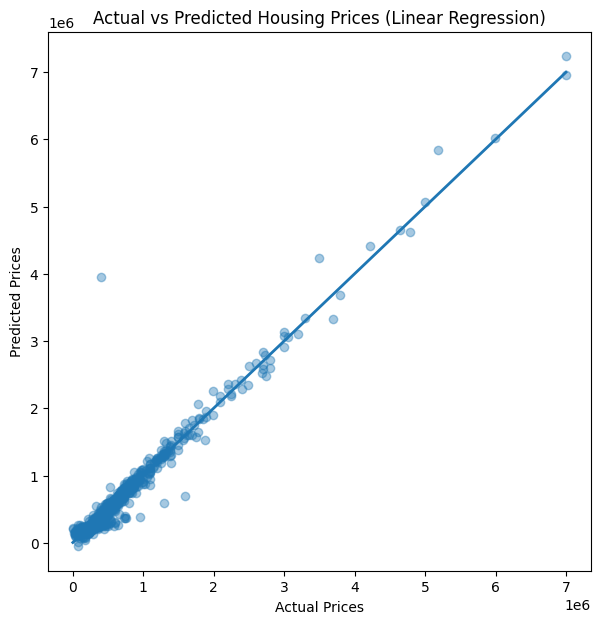

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Housing Prices (Linear Regression)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linewidth=2)  # perfect prediction line
plt.show()

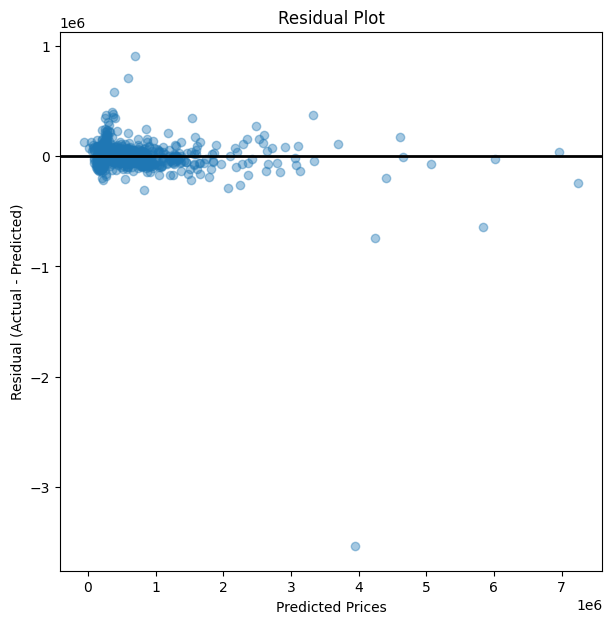

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(7,7))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='black', linewidth=2)
plt.xlabel("Predicted Prices")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

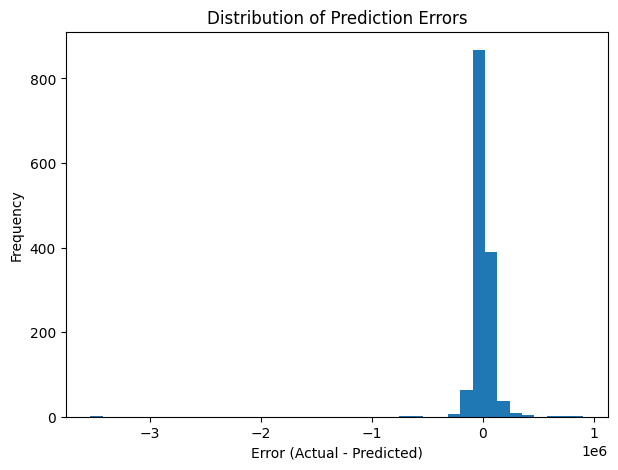

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

Saving housing_data_2016.csv to housing_data_2016 (2).csv
Loading: housing_data_2016 (2).csv
Loaded shape: (6913, 68)


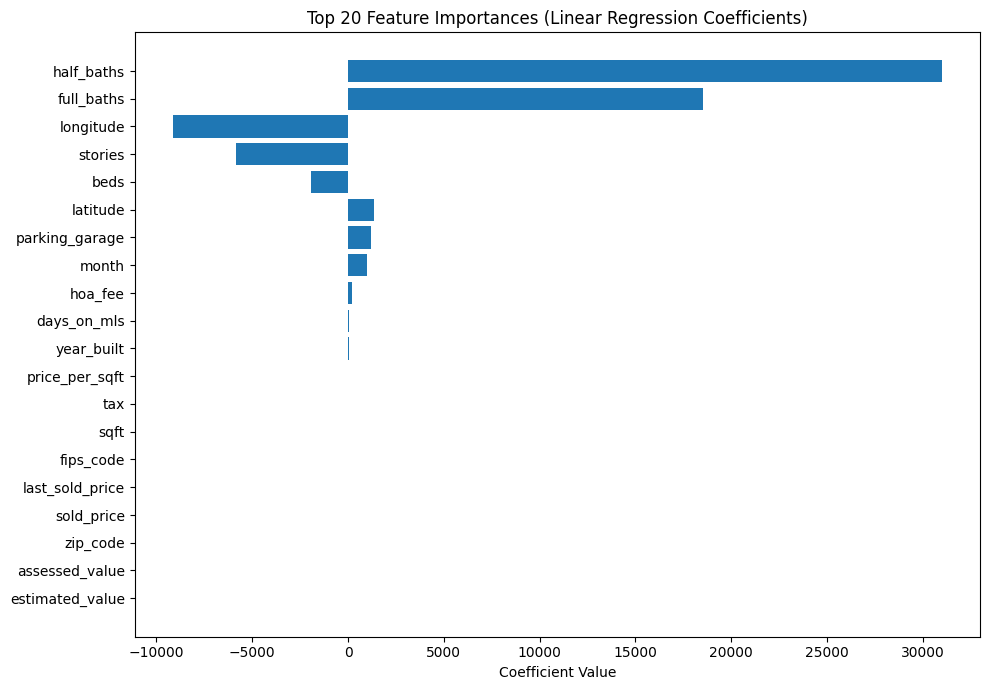

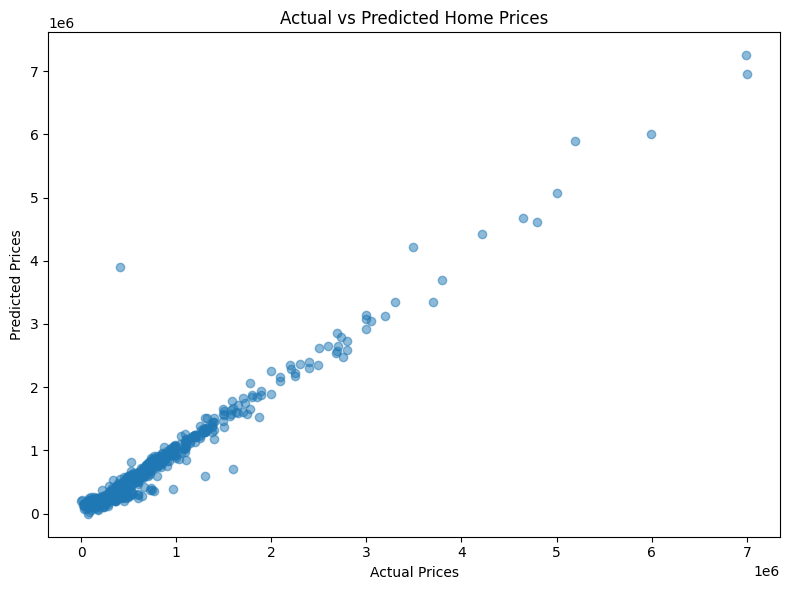

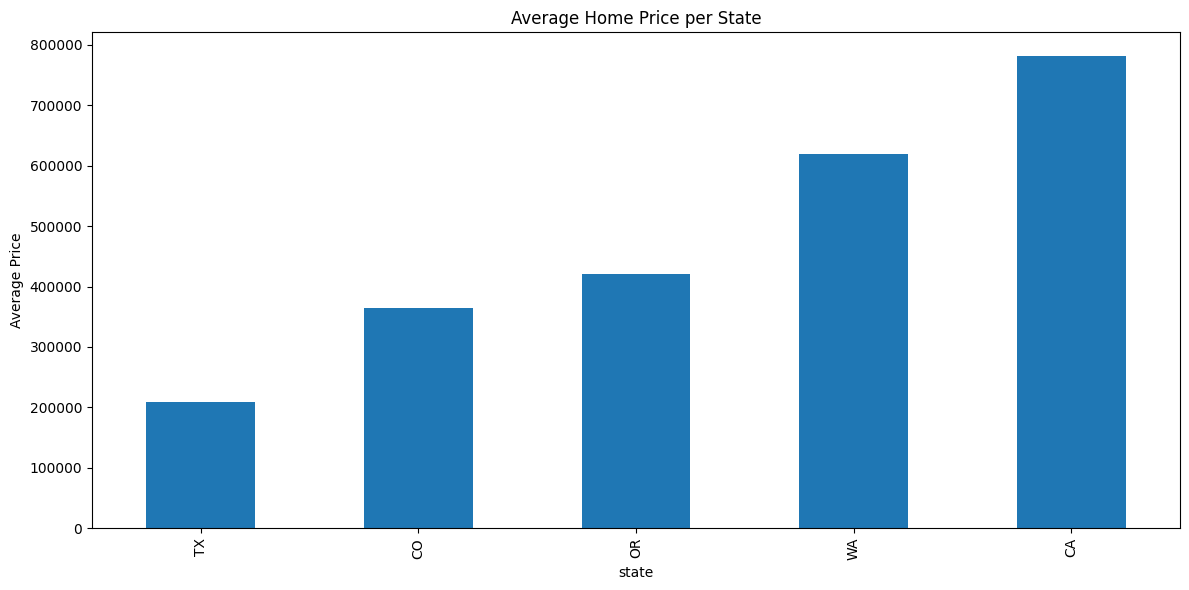

In [ ]:
# ===========================
# Upload Files
# ===========================
from google.colab import files
uploaded = files.upload()   # <-- You manually upload the two CSVs here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Uploaded files now appear in the 'uploaded' dict
# Example: uploaded.keys() -> dict_keys(['housing_data_2016.csv', 'houston_housing_data_2016.csv'])

# ===========================
# Load the uploaded CSVs
# ===========================
df_list = []

for fname in uploaded.keys():
    if fname.endswith(".csv"):
        print("Loading:", fname)
        df_list.append(pd.read_csv(fname, low_memory=False))

if not df_list:
    raise ValueError("No CSV files were loaded.")

df = pd.concat(df_list, ignore_index=True)
print("Loaded shape:", df.shape)

# ===========================
# Prepare Data
# ===========================
target = "list_price"
if target not in df.columns:
    raise ValueError("Target column 'list_price' missing.")

# numeric columns except target
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c != target]

if "state" not in df.columns:
    raise ValueError("'state' column missing.")

df = df.dropna(subset=[target, "state"])

# Average price per state
state_avg = df.groupby("state")[target].mean()
# ===========================
# Simple Regression Model
# ===========================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Keep only numeric columns
num_df = df[numeric_features].copy()

# Remove columns that are entirely NaN
num_df = num_df.dropna(axis=1, how='all')

# Now safely fill remaining NaNs
num_df = num_df.fillna(num_df.median())

# Re-split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(
    num_df, df[target], test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_
}).sort_values(by="coef", key=np.abs, ascending=False)

# ===========================
# 1. Feature Importance
# ===========================
plt.figure(figsize=(10, 7))
plt.barh(feat_imp["feature"].head(20), feat_imp["coef"].head(20))
plt.title("Top 20 Feature Importances (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===========================
# 2. Actual vs Predicted
# ===========================
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Home Prices")
plt.tight_layout()
plt.show()

# ===========================
# 3. Average Price per State
# ===========================
plt.figure(figsize=(12, 6))
state_avg.sort_values().plot(kind="bar")
plt.title("Average Home Price per State")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()


In [ ]:
!pip install scikit-learn==1.8.0
!pip install joblib

Please upload your CSV files in the file chooser that appears.


Saving housing_data_2016.csv to housing_data_2016 (4).csv
Uploaded filenames reported by files.upload(): ['housing_data_2016 (4).csv']
Reading from path: housing_data_2016.csv
Reading from path: /content/housing_data_2016.csv

Successfully loaded dataframes from: ['path:housing_data_2016.csv', 'path:/content/housing_data_2016.csv']
Combined dataframe shape: (13826, 68)

Numeric feature count before dropping all-NaN cols: 34
Dropping numeric columns that are all NaN (cannot impute): ['list_price_min', 'list_price_max', 'pending_date', 'neighborhoods', 'builder_id', 'builder_name']

Model performance:
 MSE: 7793404159.326281
 R^2: 0.9787341408218759
 MAPE: 0.23761701373620725








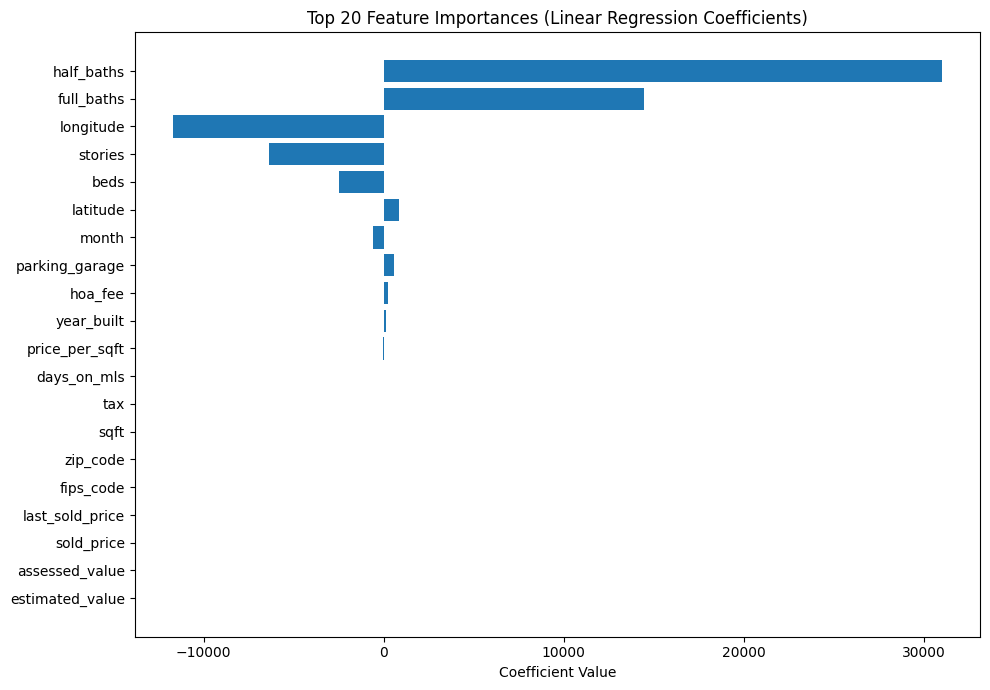

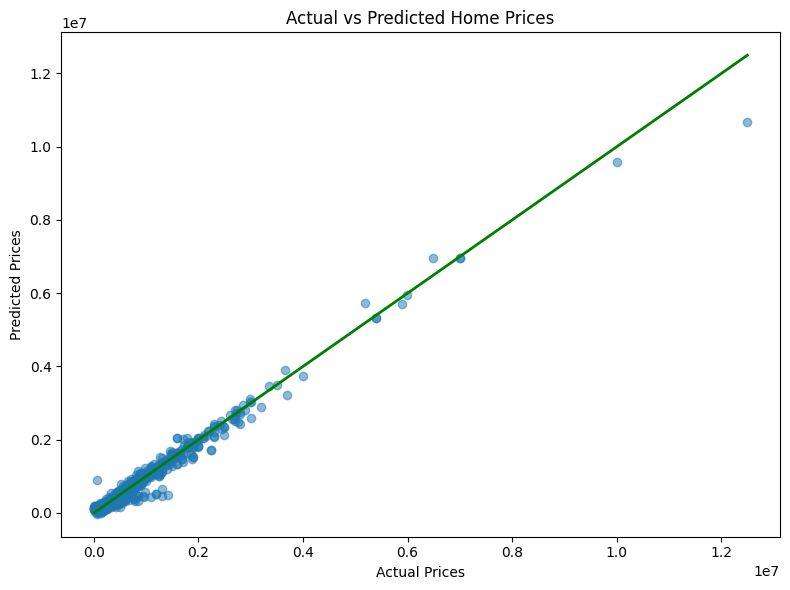

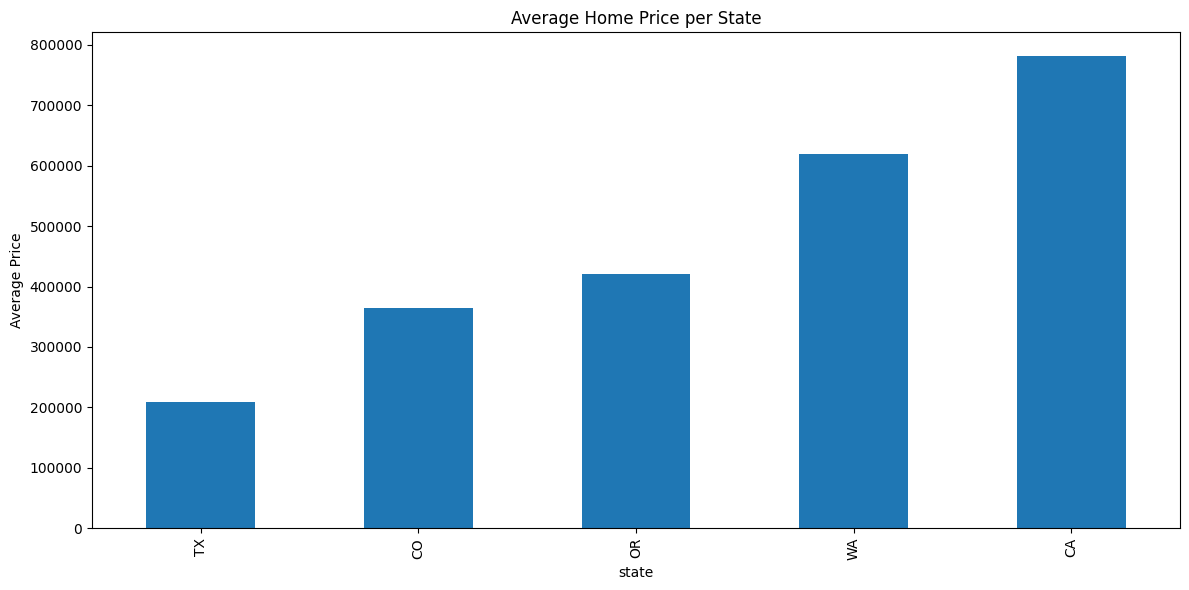








Top features and coefficients:
        feature          coef
     half_baths  30990.028788
     full_baths  14461.460472
      longitude -11698.262393
        stories  -6392.049295
           beds  -2498.261611
       latitude    844.814674
          month   -618.460577
 parking_garage    564.577250
        hoa_fee    264.371455
     year_built    128.309052
 price_per_sqft    -62.822800
    days_on_mls     37.649986
            tax     13.834575
           sqft      8.286913
       zip_code     -3.231180
      fips_code     -1.528191
last_sold_price      0.455223
     sold_price      0.455153
 assessed_value     -0.089883
estimated_value      0.027539
      broker_id      0.000232
      office_id     -0.000173
       agent_id     -0.000088
     listing_id     -0.000039
       lot_sqft      0.000019
  agent_nrds_id      0.000013
    property_id     -0.000005
           year      0.000000














In [ ]:
# Robust loader + model + plots for Colab
from google.colab import files
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Ask user to upload (if not already uploaded in this session)
print("Please upload your CSV files in the file chooser that appears.")
uploaded = files.upload()   # upload now if not already

# 2) Build list of candidate filenames and try multiple locations
candidates = [
    "housing_data_2016.csv",
    "houston_housing_data_2016.csv",
    "/content/housing_data_2016.csv",
    "/content/houston_housing_data_2016.csv",
    "/mnt/data/housing_data_2016.csv",
    "/mnt/data/houston_housing_data_2016.csv"
]

# 3) Attempt to load from uploaded dict first, then fallback to file paths
df_list = []
loaded_from = []

# uploaded is a dict of filename->bytes; check keys
uploaded_names = list(uploaded.keys()) if isinstance(uploaded, dict) else []
print("Uploaded filenames reported by files.upload():", uploaded_names)

for name in ["housing_data_2016.csv", "houston_housing_data_2016.csv"]:
    # 3a. If it's in the uploaded dict, read it directly
    if name in uploaded_names:
        try:
            print("Reading from uploaded:", name)
            df_list.append(pd.read_csv(name))
            loaded_from.append(f"uploaded:{name}")
        except Exception as e:
            print(f"Failed to read uploaded {name}: {e}")

# 3b. If still not found, try common filesystem paths
if len(df_list) == 0:
    for path in candidates:
        if os.path.exists(path):
            try:
                print("Reading from path:", path)
                df_list.append(pd.read_csv(path))
                loaded_from.append(f"path:{path}")
            except Exception as e:
                print(f"Failed to read {path}: {e}")

# 4) If still empty -> friendly error with instructions
if len(df_list) == 0:
    print("\nERROR: No CSVs were loaded. Things to check:")
    print(" - Did you run files.upload() in this session and select the files?")
    print(" - Are your files named exactly 'housing_data_2016.csv' or 'houston_housing_data_2016.csv'?")
    print(" - If you previously had the files in /mnt/data, the session may have reset; re-upload now.")
    raise ValueError("No uploaded or existing CSV files found to read.")

# 5) If at least one dataframe loaded, concat safely
if len(df_list) == 1:
    df = df_list[0].copy()
else:
    # When concatenating, allow different columns (sort=False keeps original order)
    df = pd.concat(df_list, ignore_index=True, sort=False)

print("\nSuccessfully loaded dataframes from:", loaded_from)
print("Combined dataframe shape:", df.shape)

# 6) Basic checks: target + state
target = "list_price"
if target not in df.columns:
    print("\nAvailable columns (first 50):", df.columns.tolist()[:50])
    raise ValueError(f"Target column '{target}' not found. Rename your target column or set target variable accordingly.")

if "state" not in df.columns:
    print("\nAvailable columns (first 50):", df.columns.tolist()[:50])
    raise ValueError("No 'state' column found in the dataset. If your state column has a different name, rename or modify the script.")

# 7) Clean & prepare numeric features
df = df.dropna(subset=[target, "state"])   # drop rows missing target or state

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c != target]

print(f"\nNumeric feature count before dropping all-NaN cols: {len(numeric_features)}")

# drop numeric columns that are entirely NaN
all_nan_cols = [c for c in numeric_features if df[c].isna().all()]
if all_nan_cols:
    print("Dropping numeric columns that are all NaN (cannot impute):", all_nan_cols)
numeric_features = [c for c in numeric_features if c not in all_nan_cols]

if len(numeric_features) == 0:
    raise ValueError("No numeric features remain after dropping all-NaN columns. Please provide numeric features.")

# 8) Build numeric dataframe, impute remaining NaNs with median
num_df = df[numeric_features].copy()
num_df = num_df.fillna(num_df.median())

# Sanity check: ensure no NaNs remain
if num_df.isna().any().any():
    # report which columns still have NaNs
    cols_with_nans = num_df.columns[num_df.isna().any()].tolist()
    raise ValueError(f"After imputation there are still NaNs in columns: {cols_with_nans}")

# 9) Train/test split and model (Linear Regression)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error


X_train, X_test, y_train, y_test = train_test_split(num_df, df[target], test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nModel performance:")
print(" MSE:", mean_squared_error(y_test, y_pred))
print(" R^2:", r2_score(y_test, y_pred))
print(" MAPE:", mean_absolute_percentage_error(y_test, y_pred))
print("\n")
print("\n")
print("\n")
# 10) Plots: Feature importance, Actual vs Predicted, Average price per state
import matplotlib.pyplot as plt

# Feature importance (coefficients)
coeffs = model.coef_
feat_imp = pd.DataFrame({"feature": numeric_features, "coef": coeffs})
feat_imp = feat_imp.reindex(feat_imp.coef.abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 7))
plt.barh(feat_imp["feature"].head(20), feat_imp["coef"].head(20))
plt.title("Top 20 Feature Importances (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print("\n")
print("\n")
print("\n")
# Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linewidth=2, color='Green')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Home Prices")
plt.tight_layout()
plt.show()
print("\n")
print("\n")
print("\n")
# Average price per state
state_avg = df.groupby("state")[target].mean()
plt.figure(figsize=(12, 6))
state_avg.sort_values().plot(kind="bar")
plt.title("Average Home Price per State")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()
print("\n")
print("\n")
print("\n")
# 11) Print top coefficients table
print("\nTop features and coefficients:")
print(feat_imp.head(30).to_string(index=False))
print("\n")
print("\n")
print("\n")
print("\n")
print("\n")
print("\n")


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import joblib

# =========================
# DEPLOYMENT MODEL (WEB)
# =========================
deploy_features = ["state", "beds", "sqft"]
deploy_target = target  # already detected earlier

# Keep only rows with required fields
deploy_df = df[deploy_features + [deploy_target]].dropna()

X_deploy = deploy_df[deploy_features]
y_deploy = deploy_df[deploy_target]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["state"]),
        ("num", "passthrough", ["beds", "sqft"]),
    ]
)

deploy_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

deploy_model.fit(X_deploy, y_deploy)

joblib.dump(deploy_model, "model.pkl")

print("Deployment model trained with features:", deploy_features)
print("model.pkl saved")

from google.colab import files
files.download('/content/model.pkl')

Deployment model trained with features: ['state', 'beds', 'sqft']
model.pkl saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#import sklearn, joblib
#print("sk:",sklearn.__version__)
#print("job:",joblib.__version__)

sk: 1.8.0
job: 1.5.2
